In [1]:
import numpy as np
import rospy
import matplotlib
import matplotlib.pyplot as plt
import transformations as tf
import pcl
from nav_msgs.msg import Odometry, OccupancyGrid
from geometry_msgs.msg import Twist, Point
from sensor_msgs.msg import LaserScan, Range
from numpy import sin, cos, pi
from numpy.linalg import norm

In [2]:
%matplotlib inline
%matplotlib notebook

In [102]:
class TangentBug:
    angles = None
    ranges = None
    angle_min = None
    angle_max = None
    angle_inc = None
    range_max = None
    q = None # [x, y]
    th = None # theta
    goal = None 
    ls_topic_name   = "/robot0/laser_0"
    odom_topic_name = "/robot0/odom"
    goal_topic_name = "/robot0/goal"
    last_ls_msg = LaserScan()
    def __init__(self):
        # Subscribers
        rospy.Subscriber(  self.ls_topic_name, LaserScan,   self.lsCB)
        rospy.Subscriber(self.odom_topic_name,  Odometry, self.odomCB)
        rospy.Subscriber(self.goal_topic_name,     Point, self.goalCB)
        # Set some initial values
        rospy.wait_for_message(  self.ls_topic_name, LaserScan)
        rospy.wait_for_message(self.odom_topic_name,  Odometry)
        self.angle_min = self.last_ls_msg.angle_min
        self.angle_max = self.last_ls_msg.angle_max
        self.angle_inc = self.last_ls_msg.angle_increment
        self.range_max = self.last_ls_msg.range_max
        self.goal = np.array([5., 
                              5.])
        #np.arange(self.angle_min, self.angle_max + self.angle_inc, self.angle_inc)
        self.angles    = np.linspace(self.angle_min, self.angle_max, 667) # 667 from robot specification
        
        # Publishers
        self.VelPub = rospy.Publisher("/robot0/cmd_vel", Twist, queue_size=10)
        #TODO
        rospy.loginfo("Tangent Bug Initialized")
    # LaserScan Callback
    def lsCB(self, msg):
        self.last_ls_msg = msg
        #self.ranges = self.sensor_to_robot(self.laserscan_to_numpy(msg), self.angles)
        #self.ranges = self.robot_to_world(self.th, self.q, self.ranges)
        if self.angles is not None:
            ranges_np   = self.laserscan_to_numpy(msg)
            idx         = np.where(ranges_np != np.inf)[0] # the index zero is becasue np.where returns a tuple (.,)
            self.ranges = self.sensor_to_robot(ranges_np[idx], self.angles[idx])
            self.ranges = self.robot_to_world(self.th, self.q, self.ranges)
    def odomCB(self, msg):
        self.q  = np.array([msg.pose.pose.position.x, 
                            msg.pose.pose.position.y])
        
        self.th = tf.euler_from_quaternion([msg.pose.pose.orientation.x,
                                            msg.pose.pose.orientation.y, 
                                            msg.pose.pose.orientation.z, 
                                            msg.pose.pose.orientation.w])[-1] # z component
    def goalCB(self, msg):
        self.goal  = np.array([msg.x, 
                               msg.y])
    #@staticmethod
    def sensor_to_robot(self, x, angles):
        """
        transform the values from sensor frame to robot frame
        @param  x :vals_wrt_sensor 
        @type   numpy.ndarray
        @return the sensor values wrt robot frame
        @rtype  numpy.ndarray
        """
        vals_wrt_robot = map(lambda angle, z: list(np.dot(self.Rz(angle), [z, 0])), angles, x)
        return np.array(vals_wrt_robot)
    
    def get_T(self, step_size=0.01, T_inf=True):
        x         = np.copy(self.q)
        goal      = self.goal
        pts       = self.ranges       
        range_max = self.range_max
        pt        = x
        direction = (goal - x) / norm(goal - x)
        dx        = direction * step_size
        num_steps = int(range_max / step_size)
        for i in range(num_steps):
            if self.check_colision(pt, pts) == True:
                if T_inf == True:
                    return [np.inf, np.inf]
                return pt
            pt += dx
        return pt
    def robot_to_world(self, angle, x, data):
        """
        transform the values from sensor frame to robot frame
        @param  x :vals_wrt_sensor LaserScan msg
        @type   sensor_msgs.msg.LaserScan
        @return the sensor values wrt robot frame
        @rtype  numpy.ndarray
        """
        T = self.Twr(angle, x)
        vals_wrt_world = map(lambda pt: list(np.dot(T, [pt[0], pt[1], 1])), data)
        return np.array(vals_wrt_world)[:, :-1] # the last column is all 1's
    def get_endpoints(self):
        Z = self.laserscan_to_numpy(self.last_ls_msg)
        Z[Z == np.inf] = 100
        Oindx = np.where(np.abs(np.diff(Z)) > 0.3)[0] # Z[n + 1] - Z[n]
        #print(Oindx)
        Os     = []
        Angles = []
        Os.append(Z[0])
        Angles.append(self.angles[0])
        for O in Oindx:
            Os.append(Z[O])
            Angles.append(self.angles[O])
            Os.append(Z[O + 1])
            Angles.append(self.angles[O + 1])
        Os.append(Z[-1])
        Angles.append(self.angles[-1])
        infIdx = np.where(np.array(Os) != 100.)[0]
        Os_ = self.sensor_to_robot(np.array(Os)[infIdx], np.array(Angles)[infIdx])
        return self.robot_to_world(self.th, self.q, Os_)
    @staticmethod
    def check_colision(x, pts, eps=0.025):
        """
        Check if any of the pts are in inside a ball with eps radius centered at x
        """
        if np.any(norm(x - pts, axis=-1) < eps):
            return True
        return False
    @staticmethod
    def get_normal(pts):
        """
        @param pts: points to calculate normal to their least sqaure error minimizer line
        @type numpy.ndarray
        @return the coefficient of line b + a * x (a = coef[1], b = coef[0])
        @rtype numpy.ndarray
        """
        X = np.c_[np.ones((pts.shape[0],)), pts[:, 0]] # [1, x][b, a]T
        y = pts[:, 1]
        coef = np.dot(np.linalg.pinv(X), y)
        norm = np.array([coef[1], -1]) # normal to ax - y + b = 0 is <a, -1>
        norm /= np.linalg.norm(norm)   # return the unit vector normal
        """
        to test is acutally a normal
        tangentVec = np.array([2 - 1, coef[1] * (2 - 1)])
        tangentVec /= np.linalg.norm(tangentVec)
        np.dot(pts[0,:] - pts[2,:], norm) should be ~= 0
        np.dot(tangentVec, norm) == 0
        """
        return norm
    @staticmethod
    def heuristic_fn(x, goal, pts):
        return norm(x - pts, axis=-1) + norm(pts - goal, axis=-1) 
    @staticmethod
    def get_n_minimize(x, goal, pts, hf):
        idx = np.argmin(hf(x, goal, pts))
        return pts[idx]
    def discard_Oi(self, Oi):
        x    = self.q
        goal = self.goal 
        idx = norm(Oi - goal, axis=-1) < norm(x - goal, axis=-1)
        return Oi[idx]
    @staticmethod
    def laserscan_to_numpy(ls):
        """
        @param  ls: LaserScan msg
        @type   sensor_msgs.msg.LaserScan
        @return the numpy version of the range values of the sensor
        @rtype  numpy.ndarray
        """
        vals = np.array(list(ls.ranges))
        return vals
    @staticmethod
    def Rz(angle):
        """
        @param  angle in radians
        @type   int
        @return 2x2 rotation matrix about the z axis
        @rtype  numpy.ndarray
        """
        return tf.euler_matrix(0, 0, angle)[:2, :2]
    @staticmethod
    def Twr(angle, q):
        """
        1- translational 2- rotational
        @param  angle: 
        @type   integer
        @param  pos:
        @type   numpy.ndarray
        @return 3x3 homogeneous transformation matrix
        @rtype  numpy.ndarray
        """
        T         = np.dot(tf.translation_matrix([q[0], q[1], 0.]), tf.euler_matrix(0, 0, angle))[:3, :3]
        T[:2, -1] = np.dot(tf.translation_matrix([q[0], q[1], 0.]), tf.euler_matrix(0, 0, angle))[:2, -1]
        return T
    @staticmethod
    def get_pts(vals, idx, num_pts = 1):
        """
        @param  vals [x, y] coordinates of the sensor
        @type   numpy.ndarray
        @param  idx index of the points to return the symmetic points(num_pts) around it
        @type   int
        @param  num_pts number of points to return the value around idx
        @type   int
        @return [x, y] coordinates of the points within idx - num_pts and idx + num_pts + 1
        @rtype  numpy.ndarray
        """
        lower_bound = 0              if (idx - num_pts) < 0                   else (idx - num_pts) 
        upper_bound = vals.shape[-1] if (idx + num_pts + 1) >= vals.shape[-1] else (idx + num_pts + 1)
        pts = vals[lower_bound:upper_bound, :]
        return pts
    @staticmethod
    def conca_T_Oi(Os, T):
        """
        concatenate the endpoints and T
        """
        return np.r_[Os, [list(T)]]
    def get_angle(self, x1):
        """
        the angle of the vector x2 - x1
        the vector the pointing from x1 to x2
        get_angle(q, goal)
        """
        x = x1 - self.q
        return np.arctan2(x[1], x[0])

In [103]:
rospy.init_node("TangentBug")
bug = TangentBug()

[INFO] [1526242521.383359]: Tangent Bug Initialized


In [106]:
T = bug.get_T()
Os = bug.get_endpoints()
#print(Os)
Os = bug.discard_Oi(Os)
h_pt =  bug.get_n_minimize(bug.q, bug.goal, bug.conca_T_Oi(Os, T), bug.heuristic_fn) # heading point
th_d = bug.get_angle(h_pt)
print(T, h_pt, th_d - bug.th)

([inf, inf], array([2.70918116, 2.60174619]), 0.009429429744457207)


<IPython.core.display.Javascript object>


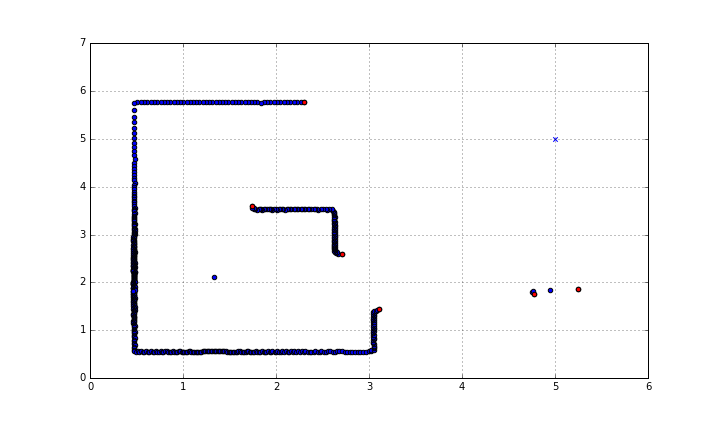

In [107]:
matplotlib.rcParams["figure.figsize"] = (10, 6)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.set_xticks(np.linspace(0., 6., 25))
#ax.set_xticks(minor_ticks, minor=True)
#ax.set_yticks(np.linspace(0., 6., 25))
#ax.set_yticks(minor_ticks, minor=True)
#plt.xlim((0, 6.))
#plt.ylim((0, 6.))
#plt.grid(True)
ax.grid(which='both')
ax.scatter(bug.ranges[:,0], bug.ranges[:, 1])
#ax.scatter(ranges[:,0], ranges[:, 1])
#ax.scatter(T[0], T[1], c='r')
ax.scatter(Os[:, 0], Os[:, 1], c='r')
#ax.scatter(mins[0], mins[1], c=[1., 1., 0., 1.])
ax.scatter(bug.goal[0], bug.goal[1], marker='x')
ax.scatter(bug.q[0], bug.q[1], marker='o')
#ax.scatter(np.r_[ranges[Os], [list(T)]][:, 0], np.r_[ranges[Os], [list(T)]][:, 1], c='r')